##Protótipo ROV
**(Recomendação e Otimização de Vendas)**

Neste projeto, estão sendo usadas duas base de dados:

* Histórico de pedidos: É o histórico de compras dos clientes. Contém as transações
* Histórico de itens: São os itens das transações

O histórico de pedidos possui pedidos de junho/2019 a novembro/2019.
Para geração das regras, serão consideradas as transações de julho de 2019 a outubro/2019 e as transações de novembro/2019 serão usadas para validação.

### 1. Setup do Ambiente

In [1]:
! pip install mlxtend==0.17 --upgrade
! pip install xlrd

     |████████████████████████████████| 1.3MB 2.7MB/s 
  Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


MLxtend é uma lilbrary para python com diversas ferramentas para tarefas de Data Science.
Dela vamos usar a ferramenta de extração de padrões frequentes.
Referência:
http://rasbt.github.io/mlxtend/

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io
import requests
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules

np.set_printoptions(threshold=None, precision=2)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('precision', 2)

### 2. Importar dados dos pedidos e seus itens

Os arquivos CSV usados no projeto encontram-se no Google Drive e, para facilitar, serão lidos diretamente.

Hist. Pedidos: https://drive.google.com/uc?export=download&id=1rq3cQBn1opDXsautvSMxmMtG-vjBfS_n

Hist. Itens:  https://drive.google.com/uc?export=download&id=11ooA-It4oPuyMw3HrJcNhg2rIMs__Wyk

Dataset de pedidos (Transações)

In [ ]:
# requisição do arquivo
s=requests.get('https://drive.google.com/uc?export=download&id=1rq3cQBn1opDXsautvSMxmMtG-vjBfS_n').content

# leitura do arquivo, já convertendo o atributo 'dtemissao' para datetime (vamos precisar disso)
df_pedidos = pd.read_csv(io.StringIO(s.decode('utf-8')), parse_dates=['dtemissao'])

print("\nDimensões do dataset de pedidos:\n{0}\n".format(df_pedidos.shape))
print("\nTipos dos dados de pedidos:\n{0}\n".format(df_pedidos.dtypes))


Dimensões do dataset de pedidos:
(26573, 9)


Tipos dos dados de pedidos:
numpedido               int64
dtemissao      datetime64[ns]
vltotal               float64
vltabela              float64
codcli                  int64
codvendedor             int64
codfilial               int64
codplpag                int64
codcob                  int64
dtype: object



**Descrição das colunas mais relevantes para o problema:**

* numpedido:  Identificador da transação
* dtemissao: Data que o pedido foi feito, data da compra
* codcli: Código do cliente para o qual o pedido foi feito

Dataset de Itens (Itens das transações)

In [ ]:
# requisição do arquivo
s=requests.get('https://drive.google.com/uc?export=download&id=11ooA-It4oPuyMw3HrJcNhg2rIMs__Wyk').content

# leitura do arquivo
df_items = pd.read_csv(io.StringIO(s.decode('utf-8')))

print("\nDimensões do dataset dos itens:\n{0}\n".format(df_items.shape))
print("\nTipos dos dados dos itens:\n{0}\n".format(df_items.dtypes))


Dimensões do dataset dos itens:
(466299, 7)


Tipos dos dados dos itens:
numpedido      int64
codprod        int64
descricao     object
sequencia      int64
qt           float64
pvenda       float64
ptabela      float64
dtype: object



**Descrição das colunas mais relevantes para o problema:**

* numpedido:  Identificador da transação
* codprod: Código do produto, do item da transação
* descricao: Descição do produto
* qt: quantidade do produto que foi inserida
* pvenda:  preço pelo qual o produto foi vendido
* ptabela: preço de tabela do produto

Período de pedidos no dataset:

In [ ]:
print('Pedido mais antigo .... ', min(df_pedidos.dtemissao))
print('Pedido mais recente ... ', max(df_pedidos.dtemissao))

Pedido mais antigo ....  2019-06-01 00:00:00
Pedido mais recente ...  2019-11-30 00:00:00


Como visto acima, na base utilizada, o pedido mais antigo é do início do mês de `Junho/2019` e o mais recente é do final do mês de `Novembro/2019`. 

Por questões de desempenho, serão usados no treino os pedidos dos meses de `Julho, Agosto, Setembro e Outubro de 2019` e para validação, serão usados os pedidos dos meses de `Novembro/2019`.

(Total de 5 meses de transações)

A validação será feita da seguinte maneira:

* Os dados serão separados de forma temporal
* Regras de associação serão geradas para a primeira parte (treino)
* Essas regras serão verificadas na segunda parte (teste)

As colunas do dataframe de pedidos, com exceção da coluna `dtemissao`, não são úteis nesse primeiro momento, então não serão usadas.

## 3. Preparação dos Dados



### 3.1 Separar Dados de Treino e Teste



Para a base de onde serão extraídas as regras de associação, serão considerados os pedidos de `Junho a Setembro`.
Para validação, serão considerados os pedidos de `Outubro e Novembro`.

In [ ]:
df_pedidos.shape

(26573, 9)

In [ ]:
# Pedidos dos meses para treino
df_ped_train = df_pedidos[df_pedidos.dtemissao < '2019-09-01']

# Validando
print('Pedido mais antigo no treino .... ', min(df_ped_train.dtemissao))
print('Pedido mais recente no treino ... ', max(df_ped_train.dtemissao))

Pedido mais antigo no treino ....  2019-06-01 00:00:00
Pedido mais recente no treino ...  2019-08-31 00:00:00


In [ ]:
df_ped_train.shape

(12486, 9)

In [ ]:
# Pedidos dos meses para teste
df_ped_test = df_pedidos[(df_pedidos.dtemissao > '2019-08-31') & (df_pedidos.dtemissao < '2019-10-01')]

# Validando
print('Pedido mais antigo no teste .... ', min(df_ped_test.dtemissao))
print('Pedido mais recente no teste ... ', max(df_ped_test.dtemissao))

Pedido mais antigo no teste ....  2019-09-01 00:00:00
Pedido mais recente no teste ...  2019-09-30 00:00:00


In [ ]:
df_ped_test.shape

(4628, 9)

**Verificando a diversidade de clientes**

Quantidade de clientes diferentes na base de treino

In [ ]:
len(df_ped_train.groupby('codcli').first())

5211

Quantidade de clientes diferentes na base de teste

In [ ]:
len(df_ped_test.groupby('codcli').first())

2858

Número de clientes na base de teste que não estão na base de treino

In [ ]:
len(df_ped_test[~df_ped_test.codcli.isin(df_ped_train.codcli)].groupby('codcli'))

766

Número de clientes na base de treino que não estão na base de teste

In [ ]:
len(df_ped_train[~df_ped_train.codcli.isin(df_ped_test.codcli)].groupby('codcli'))

3119

Agora que as transações foram separadas, os itens também devem ser separados a fim de sabermos quais itens são das transações de treino e quais são de teste. 
Basicamente, os dataframes de pedidos, treino e teste, serviram apenas para ajudar a separar os itens, mas para a geração das regra serão usados os dataframes de treino e teste dos itens.

In [ ]:
df_items.groupby('numpedido').first().count()

codprod      26326
descricao    26326
sequencia    26326
qt           26326
pvenda       26326
ptabela      26326
dtype: int64

Nas informações acima, é possível verificar que na base de dados de itens das transações, existem **26.326 transações** e não 26.573, havendo uma pequena divergência, mas que não irá atrapalhar o processo.

**Itens de Treino**

In [ ]:
df_items_train = df_items[df_items.numpedido.isin(df_ped_train.numpedido)]
df_items_train.shape

(221581, 7)

In [ ]:
df_items_train.groupby('numpedido').first().count()

codprod      12383
descricao    12383
sequencia    12383
qt           12383
pvenda       12383
ptabela      12383
dtype: int64

Na base de itens para treino, existem 14.340 transações.

**Itens de Teste**

In [ ]:
df_items_test = df_items[df_items.numpedido.isin(df_ped_test.numpedido)]
df_items_test.shape

(78501, 7)

In [ ]:
df_items_test.groupby('numpedido').first().count()

codprod      4590
descricao    4590
sequencia    4590
qt           4590
pvenda       4590
ptabela      4590
dtype: int64

Na base de dados de itens para teste existem 4.357 transações.

Somando as transações de treino (16.973) com as transações de teste (9.353), temos 26.326 transações.

Nas 16.973 transações dos 4 meses observados, existem **300.082 itens**.

Os dados ficaram divididos da seguinte maneira:

* **Treino** ..... 300.082  itens nos 16.973 pedidos (junho a setembro) ....................... `64%`
* **Tteste** ..... 166.217   itens nos 9.353 pedidos (outubro e novembro) ..................... `36%`


### 3.2 Preparação dos dados de Treino para geração das Regras de Associação



Depois de separados os dados de treino e validação, os dados de treino serão preparados para a geração da regras.

In [ ]:
# Apenas essas duas colunas serão necessárias
df_train = df_items_train.loc[:,['numpedido','codprod']]
df_train.head()

,numpedido,codprod
20,10653852,323
21,10653852,355
22,10653852,3134
23,10653852,3135
24,10653852,3787


Uma lista de listas será criada a partir do dataset de treino representando as transações e seus itens.
Cada lista é uma transação. 
Cada elemento da lista de uma lista (transação) é um item da transação.

In [ ]:
dataset_train = list(df_train.groupby('numpedido').codprod.apply(list).values)


## 4. Regras de Associação

### 4.1 Preparação para criação das regras

"Using and [TransactionEncoder](http://rasbt.github.io/mlxtend/user_guide/preprocessing/TransactionEncoder/#transactionencoder) object, we can transform this dataset into an array format suitable for typical machine learning APIs. Via the fit method, the [TransactionEncoder](http://rasbt.github.io/mlxtend/user_guide/preprocessing/TransactionEncoder/#transactionencoder) learns the unique labels in the dataset, and via the transform method, it transforms the input dataset (a Python list of lists) into a one-hot encoded NumPy boolean array:"

In [ ]:
te = TransactionEncoder()
te_ary = te.fit(dataset_train).transform(dataset_train)
te_ary

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

Agora, depois de gerado o array de lista de listas de valores booleanos, vamos criar um DataFrame a partir desse array a fim de gerarmos as regras de associação.

In [ ]:
df_train = pd.DataFrame(te_ary, columns=te.columns_)
df_train.head()

,11,16,24,36,38,39,51,53,54,57,58,59,60,97,108,112,114,128,161,162,166,170,171,187,188,193,202,212,236,237,238,249,251,260,267,271,272,273,275,276,277,278,280,281,286,293,294,297,299,323,326,336,342,344,345,346,347,348,349,354,355,359,360,363,370,390,398,406,423,424,427,431,434,439,449,450,451,452,456,457,458,461,462,471,472,473,474,475,476,478,479,480,481,486,492,495,498,500,503,505,506,521,542,543,557,558,560,572,573,575,586,587,588,594,597,598,601,604,606,613,615,616,617,623,629,631,634,635,637,638,647,649,652,657,662,664,666,667,668,681,686,688,689,694,699,700,705,706,707,722,726,727,728,729,741,742,749,751,752,753,757,758,759,760,761,766,779,780,786,797,798,817,819,821,822,828,829,831,832,833,835,836,837,839,849,851,852,867,868,869,870,884,885,888,901,921,968,973,977,985,986,987,988,989,990,991,992,993,994,995,996,1002,1003,1004,1023,1093,1094,1096,1097,1161,1245,1247,1249,1257,1259,1261,1281,1282,1283,1304,1307,1309,1310,1311,1313,1314,1315,1316,1349,1359,1360,1364,1365,1368,1370,1371,1382,1384,1405,1413,...,114325,114326,114346,114349,114362,114379,114401,114419,114439,114440,114441,114442,114443,114444,114446,114447,114448,114459,114460,114479,114481,114499,114501,114502,114569,114570,114576,114577,114578,114580,114581,114582,114583,114598,114620,114624,114625,114626,114628,114630,114631,114632,114639,114699,114700,114719,114739,114740,114741,114759,114760,114762,114779,114780,114781,114782,114784,114785,114786,114787,114788,114789,114790,114791,114792,114799,114800,114801,114802,114803,114839,114841,114859,114860,114865,114866,114867,114868,114869,114870,114871,114872,114873,114874,114875,114879,114880,114881,114882,114883,114884,114885,114886,114887,114888,114889,114899,114900,114901,114903,114907,114908,114909,114910,114911,114912,114913,114914,114916,114917,114918,114919,114920,114922,114926,114927,114928,114929,114941,114942,114943,114945,114946,114947,114948,114959,114960,114961,114962,114964,114965,114966,114967,114968,114969,114970,114971,114972,115000,115019,115022,115023,115062,115064,115068,115069,115070,115071,115079,115089,115090,115099,115100,115101,115102,115103,115104,115106,115107,115108,115109,115110,115124,115125,115126,115127,115180,115181,115199,115200,115201,115220,115261,115263,115266,115284,115285,115286,115287,115288,115289,115290,115319,115320,115321,115324,115326,115327,115379,115380,115381,115382,115383,115384,115399,115400,115401,115481,115524,115601,115602,115603,115604,115605,115606,115607,115621,115681,115684,115685,115686,115801,115819,115827,115828,115829,115833,115864,115865,115866,115867,115868,115869,115870,115880,115900,115906,115923,115924,115928,115959,115979,115981,115983,116000,116060,116101,116102,116120,116141,116151,116153,116156,116166,116183,116193,116200,116201,116204,116281
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,

Frequência dos itens nos pedidos.
O objetivo é descobrir a popularidade de um item no dataset de treino.

**Definição do Suporte Mínimo**

Normalmente, o suporte mínimo é arbritário e depende de decisão da gerência do negócio. Para bases de dados muito grandes, o suporte costuma ser menor (0.1% por exemplo) e para bases de dados muito pequenas, é maior (10% por exemplo), mas depende também de número de regras desejado.

Vamos ver a distribuição dos itens nas transações para estimar um valor razoável de suporte mínimo.


In [ ]:
ntrans = df_train.apply(lambda col: np.sum(col), axis=0)
ntrans.describe()

count    8728.00
mean       25.37
std        48.64
min         1.00
25%         4.00
50%        11.00
75%        27.00
max       960.00
dtype: float64

Em até 50% das transações, os itens aparecem em até 14 transações.
Em até 75%, os itens aparecem em até 34 transações.
Vamos usar algo entre o 2° e o 3° quartil sobre a quantidade de transações nesses quartis para determinar o suporte mínimo.

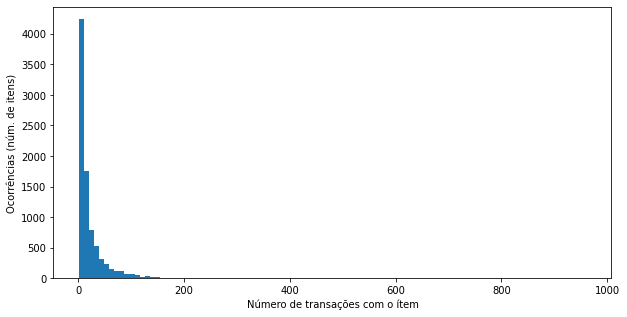

In [ ]:
plt.figure(1,figsize=[10,5])
plt.hist(ntrans,bins=100)
plt.xlabel('Número de transações com o ítem')
plt.ylabel('Ocorrências (núm. de itens)')
plt.show()

**Suporte mínimo:**

In [ ]:
minsup = ntrans.quantile(q=0.75)/len(df_train)
minsup

0.002180408624727449

### 4.2 Encontrar itemsets frequentes (FPGrowth)

O algoritimo usado no trabalho é o [FPGrowth](http://rasbt.github.io/mlxtend/api_subpackages/mlxtend.frequent_patterns/#fpgrowth). Ele é mais performático do que o Apriori, muito comum nesse tipo de problema.

A fim de otimizar o tempo para encontrar as regras, vamos limitar o tamanho dos itemsets a 4 elementos.

In [ ]:
freq_itemsets_train = fpgrowth(df_train, min_support=minsup, max_len=4, use_colnames=True)
freq_itemsets_train

,support,itemsets
0,2.11e-02,(4025)
1,9.13e-03,(99110)
2,7.19e-03,(101980)
3,5.57e-03,(4024)
4,4.36e-03,(101979)
...,...,...
31431,2.42e-03,"(86076, 86077)"
31432,2.34e-03,"(68667, 68669)"
31433,2.58e-03,"(3844, 93806)"
31434,2.58e-03,"(112092, 112093)"


### 4.3 Encontrar regras de associação

A partir dos itemset frequentes encontrados, serão geradas as [regras de associação](http://rasbt.github.io/mlxtend/api_subpackages/mlxtend.frequent_patterns/#association_rules).

A métrica usada é a `confiança` com um limiar de 70%.

In [ ]:
rules_train = association_rules(freq_itemsets_train, metric="confidence", min_threshold=0.7)
rules_train

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(51, 67087)",(106863),6.78e-03,7.06e-02,4.85e-03,0.71,10.12,4.37e-03,3.25
1,"(51, 326)",(106863),5.09e-03,7.06e-02,3.71e-03,0.73,10.35,3.36e-03,3.44
2,"(6171, 96651)",(96680),2.99e-03,4.45e-02,2.18e-03,0.73,16.40,2.05e-03,3.54
3,"(6169, 6170)",(6171),8.96e-03,1.92e-02,7.59e-03,0.85,44.06,7.42e-03,6.40
4,"(6169, 6171)",(6170),9.37e-03,1.62e-02,7.59e-03,0.81,49.92,7.44e-03,5.19
...,...,...,...,...,...,...,...,...,...
43758,(3135),(3134),1.19e-02,1.36e-02,1.03e-02,0.87,64.18,1.02e-02,7.63
43759,(96864),(96879),3.15e-03,5.25e-03,2.26e-03,0.72,136.77,2.24e-03,3.53
43760,(68669),(68667),3.23e-03,4.20e-03,2.34e-03,0.72,172.65,2.33e-03,3.62
43761,(112093),(112092),3.15e-03,5.41e-03,2.58e-03,0.82,151.65,2.57e-03,5.54


Foram encontradas **64.723 regras de associação**.

## 5. Validação

### 5.1 Verificando a precisão das regras

A partir do `df_items_test`, que é o DataFrame com os itens das transações de teste, será criada uma lista de listas onde cada lita é uma transação com seus itens.

Fazemos isso agrupando os itens pelo número do pedido (identificador da transação).

In [ ]:
dataset_test = list(df_items_test.groupby('numpedido').codprod.apply(list).values)
#4357 transações no mês de outubro (de 01/10/2019 a 30/11/2019)
len(dataset_test)

4590

In [ ]:
def get_precision_for_rule(trans, rule):
  """
    Essa função vai obter a precisão de uma regra em todas as transações de teste.
    A precisão é dada da seguinte maneira:
    
    util     = Total de transações onde os antecedentes e consequentes de uma regra aparecem
    presence = Total de transações onde os antecedentes aparecem nas transações

    precision = util / presence

    A ideia é ver em quantas transações as recomendações poderiam ocorrer para uma regra
    Depois ver em quantas dessas em que as recomendações poderiam ocorrer, o que for recomendado está presente na transação, 
    indicando uma utilidade.

    Se uma transação possui os antecedentes de uma regra, mas não possui seu consequente, entendemos isso como uma novidade para o cliente. (veremos isso na seção )

  """
  presence = 0
  util = 0
  for t in trans:
    t_set = set(t)
    if(t_set.issuperset(rule['antecedents'])):
      presence += 1
      if(t_set.issuperset(rule['consequents'])):
        util += 1
  return util / presence if presence != 0 else 0


def get_precision_for_rules(trans, rules):
  
  # return
  precision_list = []

  # LOG
  count = len(rules)
  i = 0
  current_perc = 0

  for index, row in rules.iterrows():
    precision_list.append(get_precision_for_rule(trans, row))

    # ===== LOG ======
    i += 1
    perc = (int)(i / count * 100)
    if(perc > current_perc):
      print('%s/%s ..... (%s%s)' %(i, count, perc, '%'))
      current_perc = perc

  return precision_list

`WARNING: A célula abaixo vai levar mais de 20 minutos (pode ir tomar um café ;p  )`

In [ ]:
# Obtém a precisão para cada regra em rules_train.
precision_list = get_precision_for_rules(dataset_test, rules_train)

438/43763 ..... (1%)
876/43763 ..... (2%)
1313/43763 ..... (3%)
1751/43763 ..... (4%)
2189/43763 ..... (5%)
2626/43763 ..... (6%)
3064/43763 ..... (7%)
3502/43763 ..... (8%)
3939/43763 ..... (9%)
4377/43763 ..... (10%)
4814/43763 ..... (11%)
5252/43763 ..... (12%)
5690/43763 ..... (13%)
6127/43763 ..... (14%)
6565/43763 ..... (15%)
7003/43763 ..... (16%)
7440/43763 ..... (17%)
7878/43763 ..... (18%)
8315/43763 ..... (19%)
8753/43763 ..... (20%)
9191/43763 ..... (21%)
9628/43763 ..... (22%)
10066/43763 ..... (23%)
10504/43763 ..... (24%)
10941/43763 ..... (25%)
11379/43763 ..... (26%)
11817/43763 ..... (27%)
12254/43763 ..... (28%)
12692/43763 ..... (29%)
13129/43763 ..... (30%)
13567/43763 ..... (31%)
14005/43763 ..... (32%)
14442/43763 ..... (33%)
14880/43763 ..... (34%)
15318/43763 ..... (35%)
15755/43763 ..... (36%)
16193/43763 ..... (37%)
16630/43763 ..... (38%)
17068/43763 ..... (39%)
17506/43763 ..... (40%)
17943/43763 ..... (41%)
18381/43763 ..... (42%)
18819/43763 ..... (43%)
1

In [ ]:
# Se uma regra não tinha seus antecedentes e nem seus consequentes em nenhuma transação, é retornado 0.
# Isso significa que a regra não recomenda nada para o dataset de validação. Nesse caso, ela não conta na precisão.
# Estamos validando a utilidade das regras que poderiam sugerir algo para uma transação.

precision_list = filter(lambda x: x > 0, precision_list)

**Análise da precisão:**

In [ ]:
df_prec = pd.DataFrame(precision_list)
df_prec.describe()

,0
count,43224.00
mean,0.71
std,0.27
min,0.05
25%,0.50
50%,0.75
75%,1.00
max,1.00


* A precisão média das regras é de `81%`
* Das 4.873 regras, 3.328 (`68%`) tinham seus antencedentes nas transações de teste.

Curiosidade: Verificar a precisão para os clientes que não estão na base de treino, apenas na base de testes (54 clientes)

In [ ]:
df_clientes_ineditos = df_ped_test[~df_ped_test.codcli.isin(df_ped_train.codcli)]

NameError: ignored

Abaixo a quantidade de clientes inéditos:

In [ ]:
len(df_clientes_ineditos.groupby('codcli'))

639

Filtrando os itens de transações desses 1.038 clientes inéditos.

In [ ]:
df_itens_clientes = df_items_test[df_items_test.numpedido.isin(df_clientes_ineditos.numpedido)]
df_itens_clientes.shape

(15698, 7)

In [ ]:
df_items_test.shape

(78239, 7)

O dataset original de testes possui **166.217** itens e o dataset de itens das transações de clientes que nao estão no dataset de treino possui **27.016** itens.

Iremos verificar a precisão das regras nas transações desses clientes.

In [ ]:
dataset_test_clientes = list(df_itens_clientes.groupby('numpedido').codprod.apply(list).values)
len(dataset_test_clientes)

930

São 1.692 transações para os clientes inéditos (109.511.316 iterações. Pode ir tomar um café)

In [ ]:
# Obtém a precisão para cada regra em rules_train.
precision_list_clientes = get_precision_for_rules(dataset_test_clientes, rules_train)
precision_list_clientes = filter(lambda x: x > 0, precision_list_clientes)

357/35690 ..... (1%)
714/35690 ..... (2%)
1071/35690 ..... (3%)
1428/35690 ..... (4%)
1785/35690 ..... (5%)
2142/35690 ..... (6%)
2499/35690 ..... (7%)
2856/35690 ..... (8%)
3213/35690 ..... (9%)
3569/35690 ..... (10%)
3926/35690 ..... (11%)
4283/35690 ..... (12%)
4640/35690 ..... (13%)
4997/35690 ..... (14%)
5354/35690 ..... (15%)
5711/35690 ..... (16%)
6068/35690 ..... (17%)
6425/35690 ..... (18%)
6782/35690 ..... (19%)
7138/35690 ..... (20%)
7495/35690 ..... (21%)
7852/35690 ..... (22%)
8209/35690 ..... (23%)
8566/35690 ..... (24%)
8923/35690 ..... (25%)
9280/35690 ..... (26%)
9637/35690 ..... (27%)
9994/35690 ..... (28%)
10351/35690 ..... (29%)
10707/35690 ..... (30%)
11064/35690 ..... (31%)
11421/35690 ..... (32%)
11778/35690 ..... (33%)
12135/35690 ..... (34%)
12492/35690 ..... (35%)
12849/35690 ..... (36%)
13206/35690 ..... (37%)
13563/35690 ..... (38%)
13920/35690 ..... (39%)
14276/35690 ..... (40%)
14633/35690 ..... (41%)
14990/35690 ..... (42%)
15347/35690 ..... (43%)
15704/3

Analisando a precisão para esses clientes inéditos:

In [ ]:
df_prec_cli = pd.DataFrame(precision_list_clientes)
df_prec_cli.describe()

,0
count,22695.00
mean,0.85
std,0.23
min,0.08
25%,0.70
50%,1.00
75%,1.00
max,1.00


* A precisão média das regras para os clientes inéditos é de `98%`
* Das 4.873 regras, 226 (`4.5%`) tinham seus antencedentes nessas 69 transações de teste.

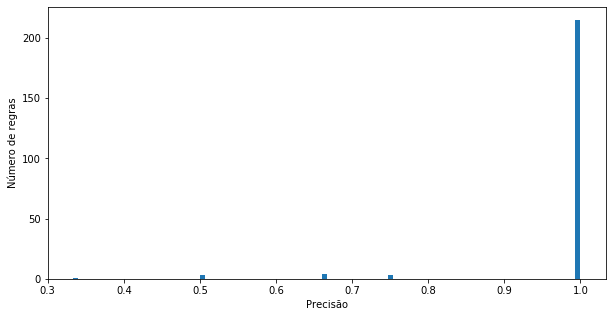

In [ ]:
plt.figure(1,figsize=[10,5])
plt.hist(precision_list_clientes,bins=100)
plt.xlabel('Precisão')
plt.ylabel('Número de regras')
plt.show()

### 5.2 Curiosidade: Verificando sugestão de novidade

In [ ]:
def filter_novelty(trans, rule):
  """
   Essa função vai retornar uma regra onde algumas das transações tinham os antecedentes, mas não tinham o consequente.
   Assim, uma nova coluna será adicionada na regra que é uma lista das transações que atenderam os antecedentes, mas não
   atenderam os consequentes.

   Se uma transação possui os antecedentes de uma regra, mas não possui seu consequente, entendemos isso como uma novidade para o cliente.
   Logo, se a precisão das regras apuradas neste trabalho foi de 80%, a novidade é de 20%.

  """
  nov_rule = rule.copy()
  carts = []

  for t in trans:
    t_set = set(t)
    if(t_set.issuperset(rule['antecedents']) and not t_set.issuperset(rule['consequents'])):
      carts.append(t)
 
  nov_rule['carts'] = carts 
  return nov_rule if len(carts) > 0 else None

O DataFrame abaixo  retorna as regras onde alguma transação tinha seus antecedentes, mas não tinha seu consequente (sugestão). 

Assim, vamos avaliar uma transação dessas e verificar se o que seria sugerido faria algum sentido.

In [ ]:
novel_list = rules_train.apply(lambda row: filter_novelty(dataset_test, row), axis=1)
novel_list = novel_list[novel_list.antecedents.notna()]

In [ ]:
novel_list

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,carts
0,"(462, 97615)",(97245),3.43e-03,4.93e-02,2.74e-03,0.80,16.21,2.57e-03,4.75,"[[336, 15192, 15732, 323, 462, 506, 6145, 6169..."
1,"(2800, 2797)",(2795),7.54e-03,2.84e-02,5.48e-03,0.73,25.57,5.27e-03,3.56,"[[112425, 100642, 107809, 111252, 112825, 1137..."
5,(68768),(68667),2.74e-03,4.11e-03,2.06e-03,0.75,182.37,2.04e-03,3.98,"[[112642, 68768, 102997, 115865, 50287, 87159,..."
8,"(58, 15189)",(15130),2.40e-03,4.97e-02,2.06e-03,0.86,17.25,1.94e-03,6.65,"[[4982, 15189, 19207, 293, 294, 355, 3705, 506..."
10,"(58, 97615)",(97245),5.14e-03,4.93e-02,3.77e-03,0.73,14.86,3.52e-03,3.56,"[[15189, 40889, 58, 97615, 97699], [97615, 151..."
...,...,...,...,...,...,...,...,...,...,...
4861,(96845),"(96840, 96853)",2.74e-03,2.74e-03,2.40e-03,0.88,319.16,2.39e-03,7.98,"[[35049, 35051, 35052, 35069, 85068, 85068, 94..."
4862,(25312),(34883),3.08e-03,2.74e-03,2.40e-03,0.78,283.69,2.39e-03,4.49,"[[107181, 102430, 102944, 102945, 103996, 1100..."
4868,(101645),(101644),3.08e-03,4.11e-03,2.40e-03,0.78,189.13,2.39e-03,4.48,"[[107876, 106902, 98307, 107874, 98541, 98542,..."
4871,(6672),(6681),2.74e-03,3.77e-03,2.06e-03,0.75,198.95,2.05e-03,3.98,"[[20057, 113342, 114590, 115324, 15347, 506, 6..."


Relembrando que a coluna `carts` é uma lista de transações onde a regra possui os antecedentes, mas não o consequente, ou seja, recomendaria uma novidade.

A partir de uma análise prévia, vamos considerar a segunda regra da lista, pois os produtos 2800 e 29797 (seus antencedentes) e o 2795 (seu consequente) são produtos de nome mais conhecido.

In [ ]:
novel_list.iloc[1]

antecedents                                                (2800, 2797)
consequents                                                      (2795)
antecedent support                                               0.0075
consequent support                                                0.028
support                                                          0.0055
confidence                                                         0.73
lift                                                                 26
leverage                                                         0.0053
conviction                                                          3.6
carts                 [[112425, 100642, 107809, 111252, 112825, 1137...
Name: 1, dtype: object

Considerando a primeira transação para essa regra (primeira lista da coluna `carts`) que tinha seus antecedentes (2800, 2797), mas não tinha seus consequentes (2795).

In [ ]:
novel_list.iloc[1]['carts'][0]

[112425,
 100642,
 107809,
 111252,
 112825,
 113779,
 113814,
 19147,
 19148,
 19150,
 2605,
 2797,
 2800,
 38307,
 38310,
 4627,
 93186]

Exibindo os produtos da transação acima para verificarmos se o item que seria sugerido seria interessante para o cliente:

In [ ]:
transacao = df_items_test[df_items_test.codprod.isin(novel_list.iloc[1]['carts'][0])].groupby('codprod').first()[['sequencia', 'qt', 'descricao']]
transacao

,sequencia,qt,descricao
codprod,,,
2605,11,1,DISJUNTOR NEMA BIPOLAR 035 AMPERES GE
2797,8,10,FITA ISOLANTE 10M FOXLUX
2800,9,10,FITA ISOLANTE 20M FOXLUX
4627,16,3,CHAVE BIELA 14MM TRAMONTINA
19147,8,1,FOGÃO CAMPER LUXO 2 BOCAS SEM MANGUEIRA BEGE S...
19148,9,1,FOGÃO CAMPER LUXO 2 BOCAS SEM MANGUEIRA AZUL S...
19150,10,1,FOGÃO CAMPER LUXO 2 BOCAS S/ MANGUEIRA VINHO S...
38307,10,1,PNEU MOTO CG 125 90/90-18 MATRIX LEVORIN
38310,11,1,PNEU MOTO CG 125 80/100-18 MATRIX LEVORIN


Destacando os produtos 2800 e 2797 na transação acima:

In [ ]:
transacao.loc[[2797, 2800]]

,sequencia,qt,descricao
codprod,,,
2797,8,10,FITA ISOLANTE 10M FOXLUX
2800,9,10,FITA ISOLANTE 20M FOXLUX


Pelo atributo `sequencia` dá para ver que os produtos foram incluídos em seguida um do outro.

Verificando o que é o produto 2795:

In [ ]:
df_items_test[df_items_test.codprod == 2795].groupby('codprod').first()[['qt', 'descricao']]

,qt,descricao
codprod,,
2795,30,FITA ISOLANTE 05M FOXLUX


Verificado que o produto `2795` também é uma fita isolante, só que de 5 metros. 

Levando em conta que os produtos `2797` e `2800` foram adicionados em sequência (uma fita isolante de 10 metros e outra de 20 metros), essa fita isolante de 5 metros seria uma boa recomendação (com respaldo de outras transações na qual esses três itens aparecem juntos).

## 6. Sugestão de Quantidade



A partir da recomendação (consequente) o sistema poderia também recomendar uma quantidade com base no histórico de vendas dos produtos.

Vamos usar o exemplo dado na seção 5.2 em que seria recomendada uma fita isolante de 5 metros se fossem incluídas as fitas isolantes de 10 e de 20 metros.

Para essa fita isolante (produto 2795), qual seria a quantidade recomendada?

Nesse caso, vamos usar o dataset de treino e validar no dataset de teste.

In [ ]:
df_sample = df_items_train[df_items_train.codprod == 2795]

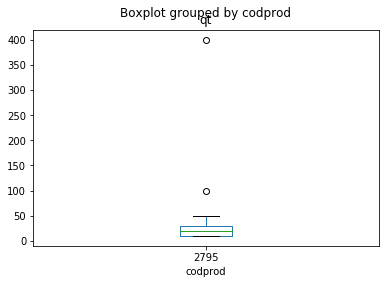

In [ ]:
df_sample.boxplot(by ='codprod', column =['qt'], grid = False) 

Tanto no histograma como pelo boxplot é possível identificarmos outliers. 

Eles serão removidos.

Vamos usar o IQR (Interquartile Range) para eliminar os outliers.

IQR = Q3 - Q1

In [ ]:
Q1 = df_sample['qt'].quantile(0.25)
Q3 = df_sample['qt'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

20.0


In [ ]:
df_sample = df_sample[~((df_sample['qt'] < (Q1 - 1.5 * IQR)) |(df_sample['qt'] > (Q3 + 1.5 * IQR)))]

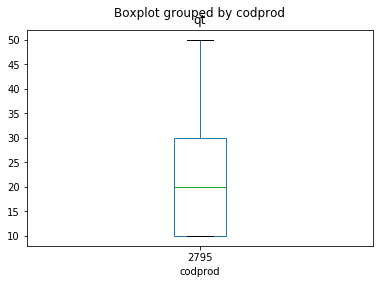

In [ ]:
df_sample.boxplot(by ='codprod', column =['qt'], grid = False) 

In [ ]:
df_sample['qt'].describe()

count    81.00
mean     23.09
std      12.51
min      10.00
25%      10.00
50%      20.00
75%      30.00
max      50.00
Name: qt, dtype: float64

### 6.1 Validando agora com a base de dados de teste

Agora a mesma análise será feita no conjunto de itens de teste (839 transações)

In [ ]:
df_sample_test = df_items_test[df_items_test.codprod == 2795]

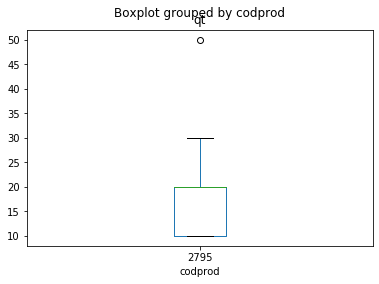

In [ ]:
df_sample_test.boxplot(by ='codprod', column =['qt'], grid = False) 

Calculando o IQR nos dados de teste:

In [ ]:
Q1 = df_sample_test['qt'].quantile(0.25)
Q3 = df_sample_test['qt'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

10.0


In [ ]:
df_sample_test = df_sample_test[~((df_sample_test['qt'] < (Q1 - 1.5 * IQR)) |(df_sample_test['qt'] > (Q3 + 1.5 * IQR)))]

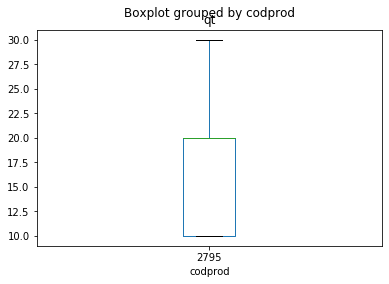

In [ ]:
df_sample_test.boxplot(by ='codprod', column =['qt'], grid = False) 

In [ ]:
df_sample_test['qt'].describe()

count    25.00
mean     18.80
std       7.26
min      10.00
25%      10.00
50%      20.00
75%      20.00
max      30.00
Name: qt, dtype: float64

**Resultado**

O 2° quartil de ambas as bases, treino e teste, tiveram o mesmo valor. 

Sendo assim, a mediana será usada como sugestão de quantidade para o consequente.

In [ ]:
df_sample['qt'].median()

20.0

In [ ]:
df_sample_test['qt'].median()

20.0